In [1]:
%matplotlib inline
from brian2 import *

## Brian's unit system

All the standard SI units are available using their name (volt, siemens, meter (or metre), second, etc.), together with standard prefixes n (nano), u (micro), m (milli), k (kilo), M (mega), etc.

Because it would lead to clashes with user-defined variable names too often, single letter names are *not* defined (e.g. no `s` or `m`), but for convenience the most commonly used abbreviations for neuroscience are available (e.g. `ms` instead of `msecond`, `mV` instead of `mvolt`, `nS` instead of `nsiemens`, etc.)

Brian complains when using physical quantities incorrectly

In [2]:
# Single values
v0 = -70*mV + exp(-3*ms/(5*ms))*10*mV
v0

-64.51188364 * mvolt

In [3]:
# Arrays of values
my_variable = [0, -10, -10, 10] * mV
mean(my_variable)

-2.5 * mvolt

In [4]:
# Incorrect use of units
3*mV + 5*nA

DimensionMismatchError: Cannot calculate 3. mV + 5. nA, units do not match (units are volt and amp).

## Neural models

Membrane potential equation:
$$
\frac{d V_m}{dt} = (I + g_L (E_L - V_m))/C_m
$$

In [5]:
start_scope()

# Constants
C_m = 200*pF
g_L = 10*nS
E_L = -70*mV
I = 1.5*nA
v_th = -50*mV

# Equation
eqs = """
dV_m/dt = (I + g_L * (E_L - V_m))/C_m : volt
"""

# Definition of the neuron model: equations, threshold, reset
group = NeuronGroup(1, eqs, threshold='V_m > v_th',
                    reset='V_m = E_L')
# Initial values
group.V_m = E_L

# Recording during the simulation (record=True means: record all neurons)
mon = StateMonitor(group, 'V_m', record=True)

run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.11s). [brian2.stateupdaters.base.method_choice]


In [6]:
# Final state variable values
group.V_m

<neurongroup.V_m: array([-59.85907299]) * mvolt>

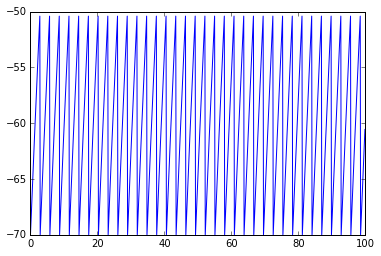

In [7]:
# Plotting the value of V_m for the first neuron
# Dividing by the scale gives unitless values in that scale
plot(mon.t/ms, mon[0].V_m/mV)

In [8]:
start_scope()

C_m = 200*pF
g_L = 10*nS
E_L = -70*mV
v_th = -50*mV

# Instead of a constant, the injected current is now a neuron-specific parameter
eqs = """
dV_m/dt = (I + g_L * (E_L - V_m))/C_m: volt
I : amp
"""

group = NeuronGroup(10, eqs, threshold='V_m > v_th',
                    reset='V_m = E_L')
group.V_m = E_L

# Different initial value for each neuron
group.I = linspace(0, 1.5, 10)*nA

mon = StateMonitor(group, 'V_m', record=True)

# Note that we get a warning about the "I" variable, because the Python variable that we
# defined in the previous cell is still available. The reference to "I" in the equations
# for V_m is therefore ambiguous because it could either refer to that constant or to the
# neuron-specific parameter. The warning tells us that Brian interprets it as the
# "internal variable", i.e. the neuron-specific parameter, which is what we want.
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
WARNING    "I" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 1.5 * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


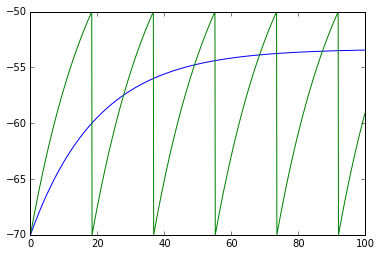

In [9]:
plot(mon.t/ms, mon[1].V_m/mV)
plot(mon.t/ms, mon[2].V_m/mV)

In [10]:
start_scope()

C_m = 200*pF
g_L = 10*nS
E_L = -70*mV
v_th = -50*mV

# Adding noise using the built-in noise variable "xi"
eqs = """
dV_m/dt = (I + g_L * (E_L - V_m))/C_m + 2*mV/sqrt(ms)*xi: volt
I : amp
"""

group = NeuronGroup(10, eqs, threshold='V_m > v_th',
                    reset='V_m = E_L')
group.V_m = E_L
group.I = linspace(0, 1.5, 10)*nA

mon = StateMonitor(group, 'V_m', record=True)
# A spike monitor records the neuron index and spike time for
# each spike. It also stores the total number of spikes per neuron.
spike_mon = SpikeMonitor(group)

run(100*ms)



INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    "I" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 1.5 * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


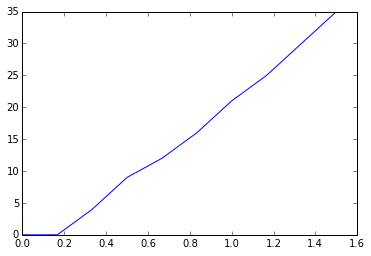

In [11]:
plot(group.I/nA, spike_mon.count)  # Spike count over input current

## Refractoriness

In [12]:
start_scope()

C_m = 200*pF
g_L = 10*nS
E_L = -70*mV
v_th = -50*mV

eqs = """
dV_m/dt = (I + g_L * (E_L - V_m))/C_m + 2*mV/sqrt(ms)*xi: volt
I : amp
"""

group = NeuronGroup(10, eqs, threshold='V_m > v_th',
                    reset='V_m = E_L',
                    refractory=5*ms)  # absolute refractory period
group.V_m = E_L
group.I = linspace(0, 1.5, 10)*nA

mon = StateMonitor(group, 'V_m', record=True)
# A spike monitor records the neuron index and spike time for
# each spike. It also stores the total number of spikes per neuron.
spike_mon = SpikeMonitor(group)

run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


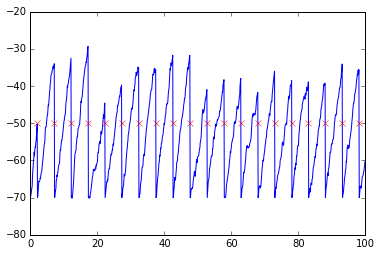

In [13]:
plot(mon.t/ms, mon[9].V_m/mV)  # Membrane potential of last neuron
spiketimes = spike_mon.spike_trains()  # Spike times for each neuron
plot(spiketimes[9]/ms, ones(len(spiketimes[9]))*v_th/mV, 'rx', clip_on=False)  # Show spike times

The above plot might look surprising: specifying a refractory period
as above does only prevent spikes from being triggered, the membrane
potential is still following its normal dynamics.
Refractory models can be quite different (e.g. only the membrane potential
is clamped to a certain value or all state variables are clamped), therefore
Brian forces you to specify your model explicitly. If we want to clamp
the membrane potential during refractoriness then we have to use the
`(unless refractory)` flag in its equation:

In [14]:
start_scope()

C_m = 200*pF
g_L = 10*nS
E_L = -70*mV
v_th = -50*mV

eqs = """
dV_m/dt = (I + g_L * (E_L - V_m))/C_m + 2*mV/sqrt(ms)*xi: volt  (unless refractory)
I : amp
"""

group = NeuronGroup(10, eqs, threshold='V_m > v_th',
                    reset='V_m = E_L',
                    refractory=5*ms)
group.V_m = E_L
group.I = linspace(0, 1.5, 10)*nA

mon = StateMonitor(group, 'V_m', record=True)
spike_mon = SpikeMonitor(group)

run(100*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


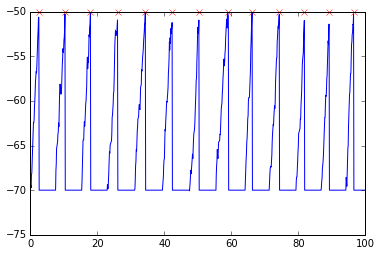

In [15]:
plot(mon.t/ms, mon[9].V_m/mV)  # Membrane potential of last neuron
spiketimes = spike_mon.spike_trains()  # Spike times for each neuron
plot(spiketimes[9]/ms, ones(len(spiketimes[9]))*v_th/mV, 'rx', clip_on=False)  # Show spike times